# From text to models in World Modelers

## Choose text corpus to process

In [9]:
text = """The government promotes improved cultivar to boost agricultural 
production for ensuring food security. However, the policy to seriously 
cut down the use of inorganic fertilizer and phase out the fertilizer 
subsidy results in deteriorating biophysical conditions, low use of inorganic
fertilizer, less water, significantly reduced farm sizes which lead to low 
benefit from the improved cultivar."""

## Read text via interface to Eidos system

In [18]:
from indra.sources import eidos
eidos_processor = eidos.process_text(text, out_format='json_ld')

## De-duplicated INDRA Influence Statements

In [19]:
statements = eidos_processor.statements

In [20]:
import indra.tools.assemble_corpus as ac
statements = ac.run_preassembly(statements)

INFO: [2018-04-10 22:57:21] indra/assemble_corpus - Combining duplicates on 5 statements...
INFO: [2018-04-10 22:57:21] indra/assemble_corpus - 5 unique statements
INFO: [2018-04-10 22:57:21] indra/assemble_corpus - Combining related on 5 statements...
INFO: [2018-04-10 22:57:21] indra/preassembler - combine_related: poolsize not set, not using multiprocessing.
INFO: [2018-04-10 22:57:21] indra/preassembler - Preassembling Influence (5)
INFO: [2018-04-10 22:57:21] indra/preassembler - Groups: 5 parent, 0 worker
INFO: [2018-04-10 22:57:21] indra/preassembler - Done running parent process groups
INFO: [2018-04-10 22:57:21] indra/preassembler - Done.
INFO: [2018-04-10 22:57:21] indra/assemble_corpus - Filtering 5 statements for top-level...
INFO: [2018-04-10 22:57:21] indra/assemble_corpus - 5 statements after filter...
INFO: [2018-04-10 22:57:21] indra/assemble_corpus - 5 top-level statements


In [21]:
statements

[Influence(fertilizer(), farm(negative)),
 Influence(farm(negative), benefit()),
 Influence(government(), cultivar(positive)),
 Influence(biophysical conditions(negative), benefit()),
 Influence(cultivar(positive), production(positive))]

## Assemble and visualize as interactive graph

In [22]:
from indra.assemblers import CAGAssembler
ca = CAGAssembler(statements)
ca.make_model()

In [23]:
from IPython.core.display import Javascript
Javascript(ca.generate_jupyter_js())

<IPython.core.display.Javascript object>

## Assemble and visualize as static graph

In [24]:
from indra.assemblers import GraphAssembler
ga = GraphAssembler(statements)
ga.make_model()
ga.save_pdf('model_graph.pdf')

In [25]:
from IPython.display import IFrame
IFrame("model_graph.pdf", width=600, height=500)

## Assemble into a system of ODEs and simulate

In [26]:
from indra.assemblers import PysbAssembler
from pysb.simulator import ScipyOdeSimulator; import numpy; import matplotlib.pyplot as plt; plt.ion()

In [27]:
pa = PysbAssembler()
pa.add_statements(statements)
model = pa.make_model()

In [28]:
import numpy
ts = numpy.linspace(0, 50000)
sim = ScipyOdeSimulator(model, ts)

In [29]:
res = sim.run()

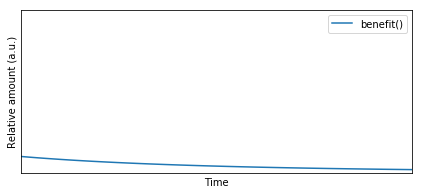

In [30]:
plt.figure(figsize=(7,3))
plt.xlim(0, 50000)
plt.ylim(0, 100000)
plt.xlabel('Time')
plt.ylabel('Relative amount (a.u.)')
plt.xticks([])
plt.yticks([])
for i, cp in enumerate(model.species):
    if str(cp) == 'benefit()':
        plt.plot(ts, res.all['__s%d' % i], label=str(cp))
plt.legend()

## Assemble into a Bayesian Network represented as a Figaro model

In [31]:
from indra.assemblers import FigaroAssembler

In [32]:
fa = FigaroAssembler(statements, readout='benefit')

In [33]:
fa.make_model()

In [34]:
print(fa.print_model('IndraModel.scala'))

import com.cra.figaro.language._
import com.cra.figaro.library.atomic._
import com.cra.figaro.library.compound._
import com.cra.figaro.library.atomic.continuous.Normal
import com.cra.figaro.algorithm.sampling.Importance

object IndraModel {
val fertilizer = Normal(1,0.2)
val farm = Chain(fertilizer, (v:Double) => Normal(v, 0.2))
val benefit = Chain(^^(farm,biophysical_conditions), (v:(Double,Double)) => Normal(+ 1.00 * v._1 + 1.00 * v._2, 0.2))
val government = Normal(1,0.2)
val cultivar = Chain(government, (v:Double) => Normal(v, 0.2))
val biophysical_conditions = Normal(1,0.2)
val production = Chain(cultivar, (v:Double) => Normal(v, 0.2))
def main(args:Array[String]) = {var importance = Importance(100000, benefit)
importance.start()
val expv = importance.computeExpectation(benefit, (v: Double) => v)
println(expv)}
}
